In [3]:
import pandas as pd

df_it = pd.read_csv("data/ITSecurity.csv")
df_se = pd.read_csv("data/SE.csv")
df_stack_1 = pd.read_csv("data/SO<2016.csv")
df_stack_2 = pd.read_csv("data/SO=2016.csv")
df_stack_3 = pd.read_csv("data/SO>2016.csv")

df_it['File'] = 'ITSecurity'
df_se['File'] = 'SE'
df_stack_1['File'] = 'Stack'
df_stack_2['File'] = 'Stack'
df_stack_3['File'] = 'Stack'

df_combined = pd.concat([df_it, df_se, df_stack_1, df_stack_2, df_stack_3], axis=0)


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('all')
stop_words = set(stopwords.words('english'))

additional_stopwords = (['using', 'working', 'like', 'could',
                         'set', 'change', 'value', 'get',
                         'load', 'getting', 'new', 'use',
                         'two', 'one', 'running', 'filter',
                         '6', '5', '1', '3'])

stop_words.update(additional_stopwords)

def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalnum()
                      and word.lower() not in stop_words]
    return ' '.join(filtered_words)

df_combined['processed_text'] = df_combined['Title'].apply(preprocess_text)
df_combined['CreationDate'] = pd.to_datetime(df_combined['CreationDate'])
df_combined = df_combined.sort_values(by='CreationDate')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/emily/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/emily/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /home/emily/nltk_data

(0, '0.080*"firebase" + 0.038*"authorization" + 0.030*"csp" + 0.028*"database" + 0.023*"security" + 0.021*"firestore" + 0.018*"403" + 0.017*"react" + 0.017*"java" + 0.015*"user"')
(1, '0.034*"header" + 0.034*"endpoint" + 0.030*"group" + 0.029*"vulnerability" + 0.022*"certificate" + 0.022*"chrome" + 0.018*"problem" + 0.017*"ssl" + 0.016*"cookie" + 0.016*"attack"')
(2, '0.118*"boot" + 0.079*"access" + 0.052*"application" + 0.041*"app" + 0.025*"rule" + 0.023*"web" + 0.020*"firestore" + 0.015*"storage" + 0.013*"allow" + 0.013*"specific"')
(3, '0.034*"android" + 0.020*"id" + 0.019*"function" + 0.019*"bean" + 0.017*"session" + 0.016*"name" + 0.016*"user" + 0.016*"found" + 0.015*"ip" + 0.015*"error"')
(4, '0.231*"spring" + 0.193*"security" + 0.051*"rules" + 0.019*"authentication" + 0.018*"login" + 0.014*"firestore" + 0.013*"user" + 0.012*"keycloak" + 0.012*"error" + 0.010*"oauth"')
(5, '0.066*"api" + 0.034*"key" + 0.026*"password" + 0.026*"rest" + 0.023*"springboot" + 0.019*"angular" + 0.018*

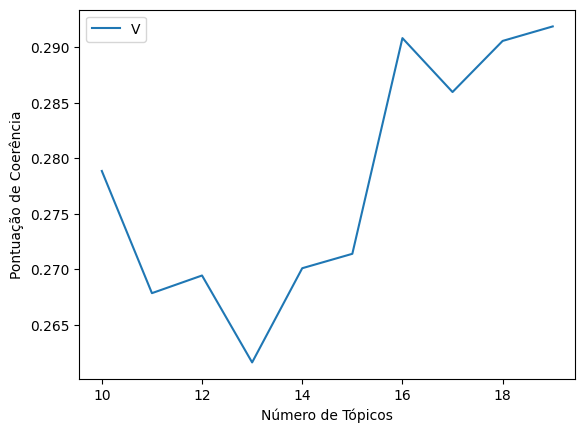

Número de Tópicos = 10, Pontuação de Coerência = 0.2789
Número de Tópicos = 11, Pontuação de Coerência = 0.2679
Número de Tópicos = 12, Pontuação de Coerência = 0.2694
Número de Tópicos = 13, Pontuação de Coerência = 0.2616
Número de Tópicos = 14, Pontuação de Coerência = 0.2701
Número de Tópicos = 15, Pontuação de Coerência = 0.2714
Número de Tópicos = 16, Pontuação de Coerência = 0.2908
Número de Tópicos = 17, Pontuação de Coerência = 0.2860
Número de Tópicos = 18, Pontuação de Coerência = 0.2906
Número de Tópicos = 19, Pontuação de Coerência = 0.2919


In [13]:
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel

texts = [text.split() for text in df_combined['processed_text']]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

def compute_coherence_score(num_topics):
    lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    df_combined['topic_assignment'] = [max(lda.get_document_topics(dictionary.doc2bow(text.split())), key=lambda x: x[1])[0] + 1 for text in df_combined['processed_text']]
    
    coherence_model = CoherenceModel(model=lda, texts=df_combined['processed_text'].apply(lambda x: x.split()), coherence='c_v')
    coherence = coherence_model.get_coherence()

    topics = lda.print_topics(num_topics=num_topics)
    for topic in topics:
        print(topic)
    print('\n')
    
    return coherence

limit = 20
start = 10
step = 1
x = range(start, limit, step)
coherence_scores = []

for num_topics in x:
    coherence_score = compute_coherence_score(num_topics)
    coherence_scores.append(coherence_score)

plt.plot(x, coherence_scores)
plt.xlabel("Número de Tópicos")
plt.ylabel("Pontuação de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

for num_topics, score in zip(x, coherence_scores):
    print(f"Número de Tópicos = {num_topics}, Pontuação de Coerência = {score:.4f}")


In [17]:
num_topics = 16

def get_top_words_per_topic(model, n_words=10):
    topic_words = []
    for topic_id in range(model.num_topics):
        words = model.show_topic(topic_id, topn=n_words)
        top_words = [word[0] for word in words]
        topic_words.append(top_words)
    return topic_words

lda = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
df_combined['topic_assignment'] = [max(lda.get_document_topics(dictionary.doc2bow(text.split())), key=lambda x: x[1])[0] + 1 for text in df_combined['processed_text']]

topic_words = get_top_words_per_topic(lda, n_words=10)

for i, words in enumerate(topic_words):
    print(f"Topic {i+1}: {', '.join(words)}")

result_df = df_combined[['Title', 'topic_assignment', 'File', 'CreationDate']]
print(result_df)


Topic 1: access, file, allow, add, read, permissions, files, document, write, restrict
Topic 2: configuration, security, group, create, function, roles, specific, need, controller, level
Topic 3: application, header, web, storage, access, project, class, denied, email, send
Topic 4: key, android, public, unable, bean, type, http, https, ip, private
Topic 5: spring, security, boot, authentication, token, oauth2, jwt, custom, authorization, oauth
Topic 6: aws, rest, security, users, requests, name, user, account, even, authenticated
Topic 7: password, azure, service, security, response, exception, windows, tokens, config, username
Topic 8: database, permission, code, failed, connect, credentials, saml, information, attack, user
Topic 9: api, app, request, cloud, method, csrf, post, call, gateway, secure
Topic 10: login, security, spring, issue, google, different, redirect, form, implement, update
Topic 11: policy, content, security, endpoint, csp, make, work, python, browser, javascript


In [18]:
num_topics = 16
output_file = "topics.txt"
output_file_details = "topics-with-details.txt"

with open(output_file, 'w') as file:
    for topic_num, topic in enumerate(lda.print_topics(num_topics=num_topics), start=1):
        words = topic[1].split('+')
        
        topic_text = ', '.join(word.split('*')[1].strip().strip('"') for word in words)
        formatted_topic = f"Topic {topic_num}: {topic_text}\n"
        file.write(formatted_topic)

with open(output_file_details, 'w') as file:
    file.write(df_combined[['Title', 'topic_assignment',
                            'File', 'CreationDate']].to_string(index=False))


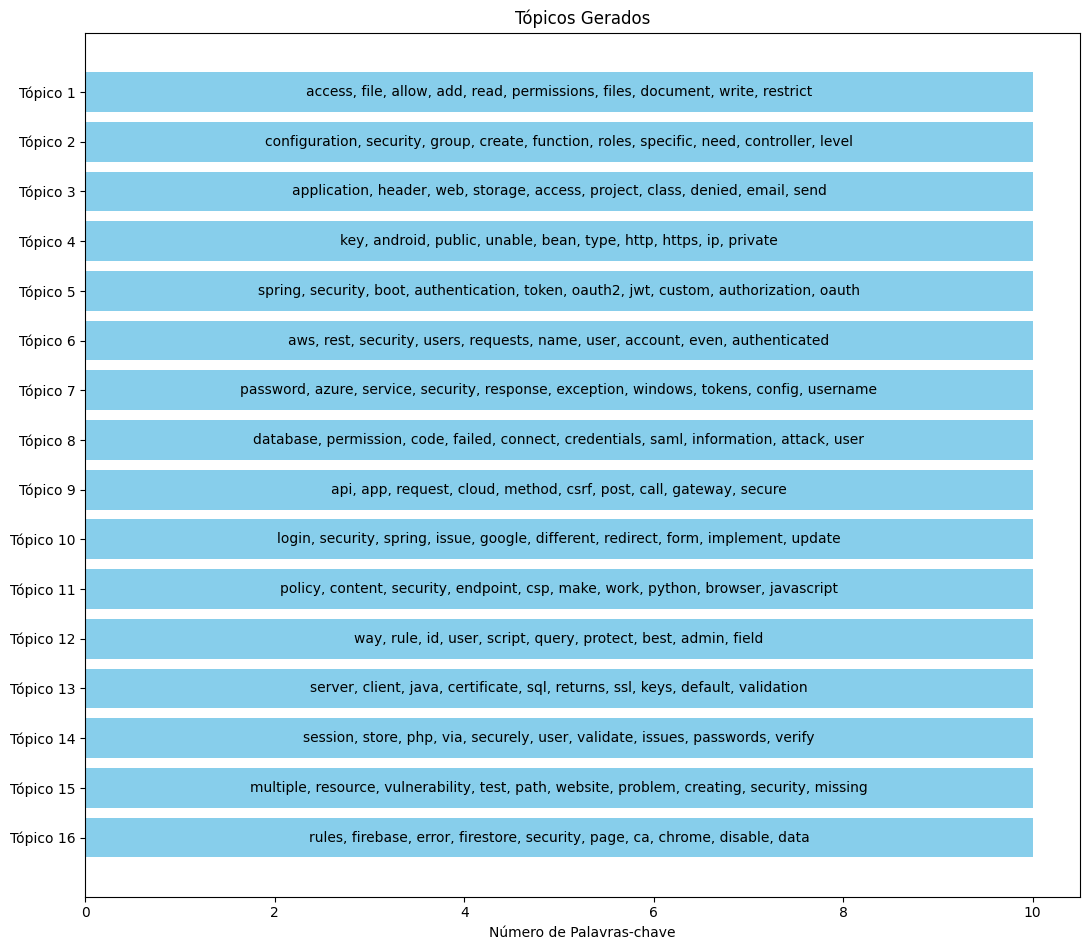

In [19]:
import matplotlib.pyplot as plt

topics = []
with open(output_file, "r", encoding="utf-8") as file:
    lines = file.readlines()
    for line in lines:
        topics.append(line.strip())

topic_keywords = [topic.split(": ")[1].split(", ") for topic in topics]

max_words = max(len(keywords) for keywords in topic_keywords)
fig_width = max_words + 1
fig_height = len(topic_keywords) * 0.6

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

for i, keywords in enumerate(topic_keywords):
    ax.barh(i, len(keywords), color='skyblue')
    text_x = len(keywords) / 2
    ax.text(text_x, i, ", ".join(keywords), ha='center', va='center', color='black')

ax.set_yticks(range(len(topic_keywords)))
ax.set_yticklabels([f'Tópico {i+1}' for i in range(len(topic_keywords))])
ax.invert_yaxis()
ax.set_xlabel('Número de Palavras-chave')
ax.set_title('Tópicos Gerados')

plt.tight_layout()
plt.show()
